In [302]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [303]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import mne
from mne.datasets import sample
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

data_path = sample.data_path()

subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
tmin, tmax = -0.200, 0.500
event_id = {"Auditory/Left": 1, "Visual/Left": 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick(picks=["grad", "stim", "eog"])

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster. The 2 Hz high-pass helps improve CSP.
raw.load_data().filter(2, 20)
events = mne.find_events(raw, "STI 014")

# Set up bad channels (modify to your needs)
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("grad", "eog"),
    baseline=(None, 0.0),
    preload=True,
    reject=dict(grad=4000e-13, eog=150e-6),
    decim=3,
    verbose="error",
)
epochs.pick(picks="meg", exclude="bads")  # remove stim and EOG

# del raw

X = epochs.get_data(copy=False)  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

Opening raw data file /Users/punyawishpatumhirunruksa/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 249 samples (1.658 s)

319 events foun

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [304]:
raw

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 9 Stimulus, 1 EOG"
Bad channels,"MEG 2443, MEG 2443"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,2.00 Hz
Lowpass,20.00 Hz


In [305]:
print(X.shape)
print(y.shape)

X_for_reduce_dimension = np.zeros((X.shape[1], X.shape[0] * X.shape[2]))

for i in range(X.shape[0]):
    X_for_reduce_dimension[:, i * X.shape[2] : (i + 1) * X.shape[2]] = X[i]

print(X_for_reduce_dimension.shape)

(123, 203, 36)
(123,)
(203, 4428)


(123, 2, 36)


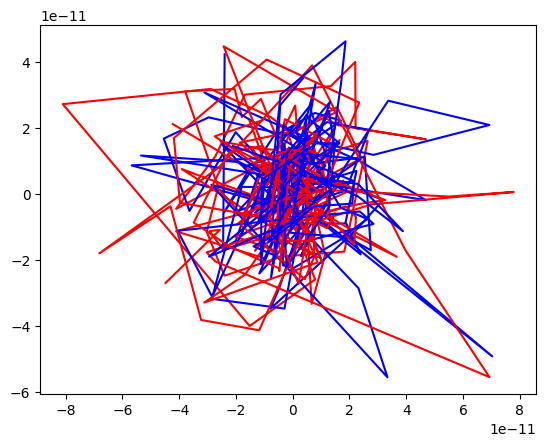

In [306]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_reduce_dimension.T).T
X_pca.shape

X_recovered = np.zeros((X.shape[0], 2, X.shape[2]))

for i in range(X.shape[0]):
    X_recovered[i] = X_pca[:, i * X.shape[2] : (i + 1) * X.shape[2]]

print(X_recovered.shape)

t = 32

for i in range(10):
    if y[i] == 1:
        plt.plot(X_recovered[i, 0, :], X_recovered[i, 1, :], color="blue")
    if y[i] == 3:
        plt.plot(X_recovered[i, 0, :], X_recovered[i, 1, :], color="red")

plt.show()

(36,)
(36,)


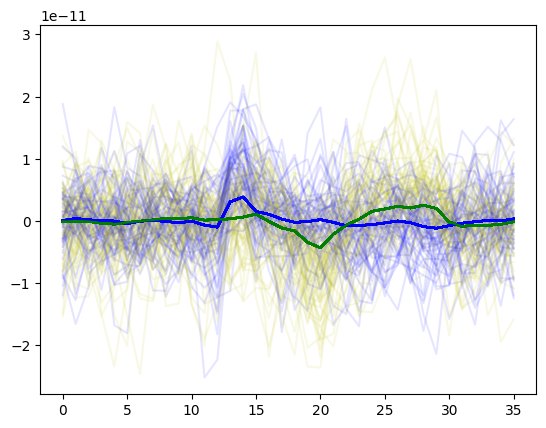

In [307]:
import matplotlib.pyplot as plt
color = ["r", "b", "g", "y"]

x_1_sum = np.zeros(36)
x_2_sum = np.zeros(36)

j = 201

for i in range(123):
    if y[i] == 1:
        x_1_sum += X[i, j, :]
    if y[i] == 3:
        x_2_sum += X[i, j, :]

print(x_1_sum.shape)
print(x_2_sum.shape)

x_1_average = x_1_sum / 123
x_2_average = x_2_sum / 123

for i in range(123):
    plt.plot(np.arange((X.shape[2])), X[i, j, :], color=color[y[i]], alpha=0.1)
    plt.plot(np.arange((X.shape[2])), x_1_average, color="b", alpha=1)
    plt.plot(np.arange((X.shape[2])), x_2_average, color="g", alpha=1)

plt.show()

In [308]:
X = X[:, :, 10:]

X.shape

(123, 203, 26)

In [309]:
X.shape

X_average_al_1 = np.zeros((203, X.shape[2]))
X_average_all_2 = np.zeros((203, X.shape[2]))

y_1_count = 0
y_2_count = 0

for i in range(123):
    if y[i] == 1:
        X_average_al_1 += X[i]
        y_1_count += 1
    if y[i] == 3:
        X_average_all_2 += X[i]
        y_2_count += 1

X_average_al_1 = X_average_al_1 / y_1_count
X_average_all_2 = X_average_all_2 / y_2_count

In [310]:
X_avg_12_stack = np.hstack((X_average_al_1, X_average_all_2))
X_avg_12_stack.shape

pca = PCA(n_components=3)
X_avg_12_stack_pca = pca.fit_transform(X_avg_12_stack.T).T
X_avg_12_stack_pca.shape

X_1_pca = X_avg_12_stack_pca[:, :36]
X_2_pca = X_avg_12_stack_pca[:, 36:]

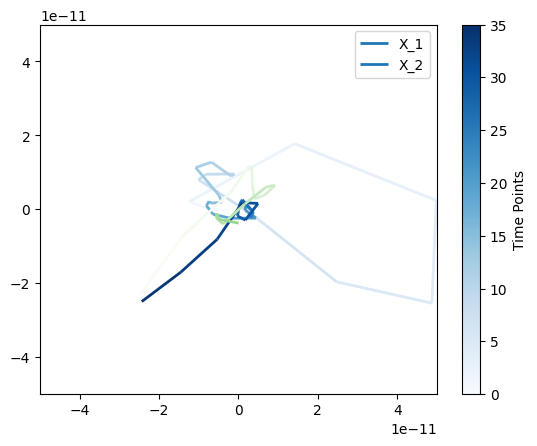

In [311]:
import matplotlib.collections as mcollections

time_points = np.arange(X_1_pca.shape[1])

# Normalize time points to range between 0 and 1 for the colormap
norm = plt.Normalize(time_points.min(), time_points.max())

# Choose a colormap (e.g., "Blues" and "Greens")
cmap1 = plt.cm.Blues
cmap2 = plt.cm.Greens

# Function to create a line collection for color shading
def create_line_collection(X, cmap, norm):
    points = np.array([X[0, :], X[1, :]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcollections.LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(time_points)
    lc.set_linewidth(2)
    return lc

# Create line collections for X_1_pca and X_2_pca
lc1 = create_line_collection(X_1_pca, cmap1, norm)
lc2 = create_line_collection(X_2_pca, cmap2, norm)

# Create the plot
fig, ax = plt.subplots()

ax.add_collection(lc1)
ax.add_collection(lc2)

# Set the limits of the plot to avoid clipping
ax.set_xlim(-5e-11, 5e-11)
ax.set_ylim(-5e-11, 5e-11)

# Add a colorbar to show the time gradient
plt.colorbar(lc1, ax=ax, label='Time Points')

plt.legend(["X_1", "X_2"])
plt.show()

In [312]:
raw

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 9 Stimulus, 1 EOG"
Bad channels,"MEG 2443, MEG 2443"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,2.00 Hz
Lowpass,20.00 Hz


In [313]:
X.shape

(123, 203, 26)

In [314]:
print(X.shape)
print(y.shape)

(123, 203, 26)
(123,)


In [315]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")

Spatio-temporal: 99.2%
